In [1]:
# 이 셀은 VSCode 환경 사용시에만 실행할 것!
%cd ..

c:\Users\jeong\Desktop\space-decomposition


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import time
import os
import cv2
from PIL import Image
import ffmpeg

import src.processing.nia2019v1 as nia
from src.models.population_estimators import PopulationEstimator

# 대화 모드
plt.ion()
plt.rcParams["figure.figsize"] = (8, 8)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
filename = "test.mp4"

resolution_str = "1024x1024"
resolution = np.array(resolution_str.split('x')).astype('int')

stream = ffmpeg.input(filename)
stream = stream.filter('fps', fps=3, round='up')
stream = stream.filter('scale', size=resolution_str)
stream = stream.output('pipe:', format='rawvideo', pix_fmt='rgb24')
frames, _ = stream.run(capture_stdout=True)
frames = (
    np
    .frombuffer(frames, np.uint8)
    .reshape([-1, resolution[1], resolution[0], 3])
)
frames.shape

(931, 1024, 1024, 3)

In [4]:
def split_frame(frame: np.ndarray):
    width, height, _ = frame.shape
    width = int(width / 2)
    height = int(height / 2)
    blocks = []
    for i in range(2):
        for j in range(2):
            blocks.append(frame[i*height:(i+1)*height, j*width:(j+1)*width])
    return blocks
    
def visualize_blocks(blocks):
    for i in range(2):
        for j in range(2):
            plt.subplot(2,2,i*2+(j+1))
            plt.axis('off')
            plt.title(i*2+j)
            plt.imshow(blocks[i*2+j])
    plt.show()

In [10]:
backbone = torchvision.models.MobileNetV2()

input_channel = 2048
backbone.classifier = nn.Sequential(
            nn.Linear(backbone.last_channel, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(),
        )

model = PopulationEstimator(backbone, input_channel, 4)
state_dict = torch.load("outputs/models/model512_0.pt")
model.load_state_dict(state_dict)
model.to(device)
model.eval()
print()

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
])

In [15]:
def predict(model, blocks):
    print(type(blocks))
    inputs = [transform(cv2.resize(block, dsize=(512, 512))).unsqueeze_(0) for block in blocks]
    inputs = torch.cat(inputs)
    labels, existences = model(inputs.to(device))
    # 각 블록당 라벨, 각 블록당 존재율
    return labels.argmax(1).cpu().detach().numpy(), existences.cpu().detach().numpy()

In [16]:
def visualize_prediction(blocks, labels, existences):
    for i in range(2):
        for j in range(2):
            plt.subplot(2,2,i*2+(j+1))
            plt.axis('off')
            idx = i*2+j
            plt.title(f"idx: {idx}, label: {labels[idx]}, existence: {existences[idx]}")
            plt.imshow(blocks[idx])
    plt.show()

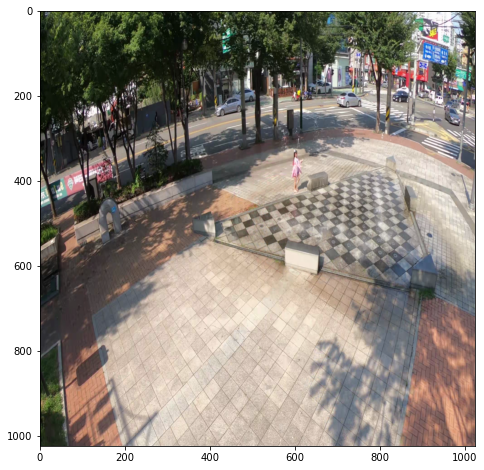

In [22]:
plt.imshow(frames[150])

<class 'list'>


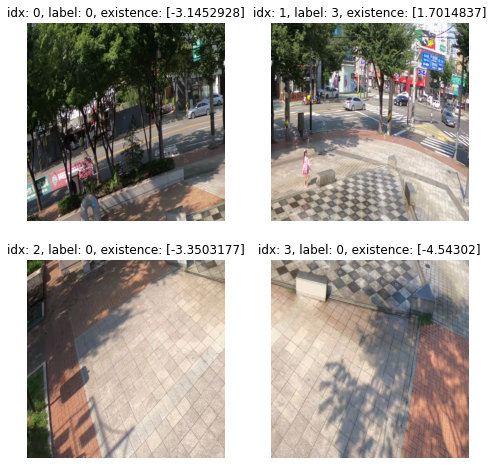

(array([0, 3, 0, 0], dtype=int64),
 array([[-3.1452928],
        [ 1.7014837],
        [-3.3503177],
        [-4.54302  ]], dtype=float32))

In [19]:
frame = frames[150]
blocks = split_frame(frame)
labels, existences = predict(model, blocks)
visualize_prediction(blocks, labels, existences)
labels, existences

<class 'list'>


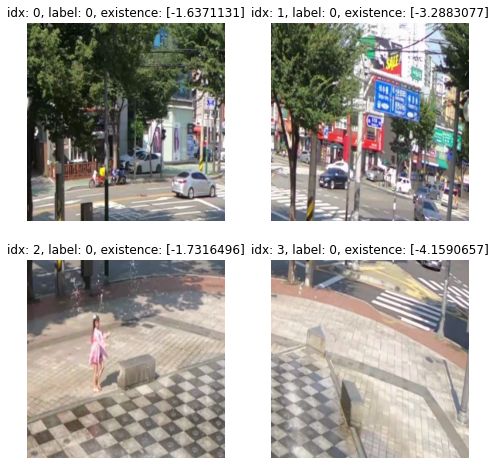

(array([0, 0, 0, 0], dtype=int64),
 array([[-1.6371131],
        [-3.2883077],
        [-1.7316496],
        [-4.1590657]], dtype=float32))

In [21]:
frame = blocks[existences.argmax()]
blocks = split_frame(frame)
labels, existences = predict(model, blocks)
visualize_prediction(blocks, labels, existences)
labels, existences